# Comparison MB and MB-LF vs Dynamic Mini-Batching (MB-D)

O experimento a seguir utilizou as seguintes configurações:



### MB-Dynamic

- Mini Batching: Váriavel de 50 à 2000
- Ensemble: 25

Nota: Os experimentos das execuções 5 a diantes precisam ser refeitos pois não rodou o script de carga da CPU

### MB Loop Fusion (Socket Random)

- Mini-Batching: 25, 50, 500, 2000
- Ensemble: 25

### MB (Socket Random)

- Mini-Batching: 25, 50, 500, 2000
- Ensemble: 25

In [998]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.4f}'.format

# inicia os metodos de parser e auxiliares

# MB-LF

In [999]:
%cd /Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy
/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/results


In [1000]:
# sizes availables (25, 50, 500, 2000)
MB_SIZE = 500
EXECUTION = 0

In [1001]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string

    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [1002]:
def add_label_column_df(df):
    df_new = df[df.batch_size == MB_SIZE]
    
    return df_new

In [1003]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    #return select_columns_and_rename_values(df)
    return df

In [1004]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [1005]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

## Carrega os dados do MB-LF com Random Socket

In [1006]:
%cd /Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/results/loop-fusion/dynamic-socket"
wantedCSVfilename = "data-batch.csv"

PATH_TO_RESULTS = folderMOADumps

/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy


In [1007]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
experiments = range(1, 6)
dfs = []
header_printed = False

for experiment in experiments:
    with open(f"{csvFile}-{experiment}", "w+") as output:
        _dir = os.fsencode(f'{resultsFolder}/{experiment}')

        for file in os.listdir(_dir):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse(f'{os.fsdecode(_dir)}/{filename}')}\n")

    load_df(f'{csvFile}-{experiment}')


In [1008]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','

    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True

        return (pstr[:-1])

In [1009]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
                'instances', 'time', 'delay', 'out_rate', 'acc']]

In [1010]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [1011]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [1012]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [1013]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 
               'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [1014]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')

                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, bsize, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

In [1015]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [1016]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [1017]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.10

    alg_order = ['MB-LF', 'MB-D']
    labels = ['10%', '50%', '90%']

    line_format = ['dotted', '.']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 1
    for i in range(versions):
        adf = df.iloc[i]

        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [1018]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []

    df_mbd = df[df.label == "MB-D"]
    df = df.drop(df[df.label == "MB-D"].index)

    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#         display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # display(showdf)

        df_mbd = filter_by_substring_algorithm(df_mbd, alg).sort_values(['algorithm','batch_size','cores'])
        df_mbd = df_mbd[df_mbd.dataset == ds]
        showdf = pd.concat([showdf, df_mbd])

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False

            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)    

In [1019]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.5, -0.10))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [1020]:
def read_data_create_final_dataframe(experiment, DEBUG=False, times='first'):
    d = {}
    global header_printed
    header_printed = False

    folder_path = f"{PATH_TO_RESULTS}/{experiment}"

    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    # d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')

    #join dfs
    finaldf = moaDF.merge(mdf, on=[ 'algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])

    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}/tdf.csv")    
    return tdf

In [1021]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

## Carrega os dados do MB-LF com Socket Random combinando com os resultados de energia

In [1022]:
experiments = range(1, 6)
dfmblf2 = []
for experiment in experiments:
    df_temp = read_data_create_final_dataframe(experiment, True)
    df_temp = add_label_column_df(df_temp)
    df_temp['label'] = f'MB-LF-{MB_SIZE}'
    df_temp['IPS'] = df_temp['instances'] / df_temp['time']

    dfmblf2.append(df_temp)


moaDF: 120    mdf: 120     sshDF: 118


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2308523548.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 120    mdf: 120     sshDF: 151


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2308523548.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2308523548.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 94


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2308523548.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 120    mdf: 96     sshDF: 94


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2308523548.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


# Prepare Data MB Dynamic

In [1023]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [1024]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return df

In [1025]:
#Folder inside results directory that contains all the MOA dump files for these experiments
for experiment in range(1, 11):
    folderMOADumps = f"results/coletor-energia/dynamic-batch/{experiment}/"
    wantedCSVfilename = "data-batch-vs-acc.csv"

    resultsFolder = f"{folderMOADumps}"
    csvFile = f"parsed_csvs/{wantedCSVfilename}"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

    dfmbd = load_df(f'{csvFile}')
    dfmbd['label'] = 'MB-D'

In [1026]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [1027]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    return df[['algorithm', 'dataset', 'cores',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [1028]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [1029]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')

                if len(spline) == 2:
                    dataset,algorithm = spline
                else:
                    dataset,algorithm = *spline,1

                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}

            
                d[algorithm][dataset] = {'start': date_time_obj, 'finish': ''}
                dnow = d[algorithm][dataset]

                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True

    return d

In [1030]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            st = v1['start']
            ed = v1['finish']
            v1['seconds'] = (ed - st).seconds
            new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                        & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
            v1['avg_measure'] = new_df['measure'].mean()
            v1['sum_measure'] = new_df['measure'].sum()
            v1['avg_times_seconds'] = v1['avg_measure'] * v1['seconds']
    return d

In [1031]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            dappend['algorithm'].append(kalg)
            dappend['dataset'].append(kds)
            dappend['ensemble_size'].append(25)
            dappend['cores'].append(4)
            dappend['batch_size'].append('Dynamic')
            dappend['duration'].append(vds['seconds'])
            dappend['inc_rate'].append(100)
            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                dappend[key].append(vds[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]

In [1032]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg = spline[1:]
                    else:
                        dataset, alg = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d)

In [1033]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [1034]:
PATH_TO_RESULTS = '/Users/reginaldo.junior/Documents/Ufscar/tecnhiques-reduce-consumption-energy'

In [1035]:
def read_data_create_final_dataframe(DEBUG=False, experiment=1):
    d = {}
    global header_printed
    header_printed = False
    folder_path = f"{PATH_TO_RESULTS}/results/coletor-energia/dynamic-batch/{experiment}/"

    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')

    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')

    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['IPS'] = finaldf['instances'] / finaldf['time']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm'], ascending=False)

    tdf['tput'] = tdf['instances'] / tdf['time']
    tdf.to_csv(f"{PATH_TO_RESULTS}/results/coletor-energia/dynamic-batch/{experiment}/dynamic-batch.csv")    
    return tdf

## Carrega os dados do MB-D com o Socket Random e cruzando os dados de energia

In [1036]:
pd.set_option('display.precision', 10)

experiments = range(1, 11)
dfmbd = []

for experiment in experiments:
    df_temp = read_data_create_final_dataframe(True, experiment)
    df_temp['label'] = 'MB-D'
    df_temp['cores'] = 4
    df_temp['PERC'] = 'Random'
    df_temp['IPS'] = df_temp['instances'] / df_temp['time']

    dfmbd.append(df_temp)

moaDF: 24    mdf: 24     sshDF: 24


moaDF: 21    mdf: 21     sshDF: 21
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24
moaDF: 24    mdf: 24     sshDF: 24


In [1037]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [1038]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [1039]:
def read_data_create_final_dataframe(DEBUG=False, experiment = 1):
    d = {}
    global header_printed
    header_printed = False
    folder_path = f"{PATH_TO_RESULTS}/results/coletor-energia/mini-batching/random-socket/{experiment}"

    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    tdf.to_csv(f"{PATH_TO_RESULTS}/results/coletor-energia/mini-batching/random-socket/{experiment}/tdf.csv")    
    
    return tdf

In [1040]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [1041]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [1042]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [1043]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

## Carrega os dados cruzando com a informação de energia do MB com o Socket Random

In [1044]:
pd.set_option('display.precision', 10)

dfmb = []
for experiment in range(1, 11):
    df_temp = read_data_create_final_dataframe(True, str(experiment))
    df_temp = add_label_column_df(df_temp)
    df_temp['label'] = f"MB-{MB_SIZE}"
    df_temp['IPS'] = df_temp['instances'] / df_temp['time']

    dfmb.append(df_temp)

moaDF: 96    mdf: 96     sshDF: 99


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 100


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 98


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 96


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


moaDF: 96    mdf: 96     sshDF: 98


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/2401523173.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


In [1045]:
## lembrar de dinamizar esse bloco pois está pegando somente um experimento
dfmblf2[EXECUTION] = dfmblf2[EXECUTION].drop(dfmblf2[EXECUTION][dfmblf2[EXECUTION].cores == 1].index)

dfmbd[EXECUTION]['batch_size'] = '50-2000'

columns = ['algorithm', 'dataset', 'cores', 'batch_size', 'instances', 'time', 'delay', 'acc', 'joules', 'JPI', 'PERC', 'label', 'IPS']
dataframes = pd.concat([
    dfmb[EXECUTION][columns],
    dfmblf2[EXECUTION][columns], 
    dfmbd[EXECUTION][columns]
])

In [1046]:
def transformar_dataframe_unico_salvar_csv(lista_dataframes, file_path):
    columns = ['dataset', 'algorithm', 'batch_size', 'acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay', 'IPS']

    df_combined = pd.concat(lista_dataframes)
    df_combined = select_columns_and_rename_values(df_combined.loc[:, columns])
    
    df_combined.to_csv(file_path)

In [1047]:
transformar_dataframe_unico_salvar_csv(dfmblf2, f"{PATH_TO_RESULTS}/results/mblf_socket_dynamic.csv")
transformar_dataframe_unico_salvar_csv(dfmb, f"{PATH_TO_RESULTS}/results/mb_socket_dynamic.csv")
transformar_dataframe_unico_salvar_csv(dfmbd, f"{PATH_TO_RESULTS}/results/mblf_mb_and_socket_dynamic.csv")

In [1048]:
dfmb = dfmb[EXECUTION]
dfmblf2 = dfmblf2[EXECUTION]
dfmbd = dfmbd[EXECUTION]

In [1049]:
def gen_graph_joules(df_minimum, df_maximum, execution='first', only_eficiency=False):
    filename = f"ips-jpi-all-algorithms"
    # fig, axs = plt.subplots(4, 5, figsize=(24, 14), tight_layout=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.8, 'bottom': 0.1}, layout='constrained')
    fig, axs = plt.subplots(4, 6, figsize=(26, 14), tight_layout=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.8, 'bottom': 0.1}, layout='constrained')

    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    # algorithms = ['ARFMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']
    algorithms = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']

    # Define a largura das barras
    bar_width = 0.20

    for ds in datasets:
        current_df = df_minimum[(df_minimum.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:
            my_id = algorithms.index(alg)
            dfalg = filter_by_substring_algorithm(current_df, alg).sort_values(['algorithm','batch_size','cores'])
            
            df_mapping = pd.DataFrame({
                'label': [f'MB-{MB_SIZE}', f'MB-LF-{MB_SIZE}', 'MB-D'],
            })
            sort_mapping = df_mapping.reset_index().set_index('label')
            dfalg['label_num'] = dfalg['label'].map(sort_mapping['index'])

            dfalg = dfalg.drop_duplicates().sort_values('label_num')
            display(dfalg)

            c1 = 'tab:green'
            c2 = 'tab:blue'
            c3 = 'tab:red'
            
            labels = dfalg.label
            x = np.arange(len(labels))

            # Define a posição dos eixos x para cada barra
            x1 = np.arange(len(x))
            x2 = [x + bar_width for x in x1]
            x3 = [x + bar_width for x in x2]

            # Plota as barras lado a lado
            ax = axs[int(my_id_ds)][my_id%6]
            ax.bar(x1, pd.to_numeric(dfalg.JPI), color=c1, width=bar_width, linewidth=0.2, label='JPI')
            ax.tick_params(axis='y', labelcolor=c1)

            ax2 = ax.twinx()
            ax2.bar(x2, pd.to_numeric(dfalg.IPS), color=c2, width=bar_width, linewidth=0.2, label='IPS')
            ax2.tick_params(axis='y', labelcolor=c2)

            ax3 = ax.twinx()
            ax3.bar(x3, pd.to_numeric(dfalg.delay), color=c3, width=bar_width, linewidth=0.23, label='Delay')
            ax3.tick_params(axis='y', labelcolor=c3)

            ax3.spines["right"].set_position(("axes", 1.255))

            ax.set_title(f'{alg}')
            
            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(f'{ds}')

            # Ajusta as posições do eixo x e adiciona os rótulos
            ax.set_xticks(x1 + bar_width/2)
            ax.set_xticklabels(labels)
            
            if (my_id%6 == 0 and my_id_ds%4 == 0):
                ax.legend(loc='lower center', bbox_to_anchor=(2.7, -5))
                ax2.legend(loc='lower center', bbox_to_anchor=(3.3, -5))
                ax3.legend(loc='lower center', bbox_to_anchor=(4.3, -5))
            

    #retrieves the handles and labels to create a global legend
    # handles, labels = axs[0][0].get_legend_handles_labels()
    # lgd = fig.legend(handles, labels, loc = 'lower center')

    plt.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_inches='tight', format='eps', dpi=1200)
    plt.show()

In [1050]:
## separate dataframes by rate thoughtput
df = dataframes

columns = ['dataset', 'algorithm', 'batch_size', 'acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']

mblf_socket_dynamic = select_columns_and_rename_values(dfmblf2.loc[:, columns])

mb_socket_dynamic = select_columns_and_rename_values(dfmb.loc[:, columns])

mblf_mb_and_socket_dynamic = select_columns_and_rename_values(df[df.PERC == 'Random'].loc[:, columns])

# Comparando o MB Dinamico com MB and MB-LF Fixo com Socket Random

/Users/reginaldo.junior/Library/Python/3.11/lib/python/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'tight_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
81,airlines,ARFMB,500,64.5844,"10,713.0000",599.2640,0.1860,"1,970.3339",4,MB-500,"18,402.0000",17.8769,0
47,airlines,ARFMB,500,66.7972,"36,500.0000",601.1070,0.0738,"2,676.1658",4,MB-LF-500,"6,821.0000",60.7213,1
11,airlines,ARFMB,50-2000,65.0979,"11,751.0000",120.5970,0.0606,645.8695,4,MB-D,"2,537.0000",97.4402,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
36,airlines,LBagMB,500,62.5203,"6,650.0000",599.2720,0.2841,"1,859.0530",4,MB-500,"25,563.0000",11.0968,0
94,airlines,LBagMB,500,58.2885,"26,500.0000",599.2830,0.3534,"3,492.5941",4,MB-LF-500,"9,926.0000",44.2195,1
7,airlines,LBagMB,50-2000,63.7833,"6,001.0000",123.8140,0.1256,686.0399,4,MB-D,"41,114.0000",48.4679,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
25,airlines,SRPMB,500,65.1130,"8,374.0000",599.2590,0.2369,"1,949.1457",4,MB-500,"24,765.0000",13.9739,0
78,airlines,SRPMB,500,68.0548,"31,500.0000",606.3460,0.0917,"2,870.5522",4,MB-LF-500,"8,515.0000",51.9505,1
8,airlines,SRPMB,50-2000,64.8457,"8,751.0000",122.5750,0.0835,668.6643,4,MB-D,"3,462.0000",71.3930,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
48,airlines,OBAdwinMB,500,64.4211,"30,633.0000",599.2920,0.0631,"1,911.3193",4,MB-500,"6,043.0000",51.1153,0
46,airlines,OBAdwinMB,500,67.9838,"117,500.0000",599.3630,0.0215,"2,493.9976",4,MB-LF-500,"2,035.0000",196.0415,1
4,airlines,OBAdwinMB,50-2000,66.7382,"34,001.0000",120.2460,0.0215,661.6025,4,MB-D,"1,764.0000",282.7620,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
54,airlines,OBASHTMB,500,64.7110,"28,333.0000",599.2890,0.0673,"1,882.0958",4,MB-500,"6,365.0000",47.2777,0
118,airlines,OBASHTMB,500,61.6145,"531,500.0000",380.0720,0.0038,"1,981.9364",4,MB-LF-500,356.0000,"1,398.4193",1
3,airlines,OBASHTMB,50-2000,64.9169,"22,251.0000",121.7720,0.0236,477.1658,4,MB-D,"1,365.0000",182.7267,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
84,airlines,OBMB,500,63.5519,"27,500.0000",605.1260,0.0755,"2,056.3841",4,MB-500,"7,183.0000",45.4451,0
56,airlines,OBMB,500,59.9586,"524,500.0000",415.2820,0.0039,"2,012.1259",4,MB-LF-500,361.0000,"1,262.9972",1
21,airlines,OBMB,50-2000,62.3276,"286,001.0000",120.0570,0.0024,621.6063,4,MB-D,209.0000,"2,382.2101",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
79,GMSC,ARFMB,500,93.4111,"48,702.0000",599.3250,0.0361,"1,741.1188",4,MB-500,"3,402.0000",81.2614,0
112,GMSC,ARFMB,500,93.5358,"150,000.0000",308.7490,0.0065,965.3880,4,MB-LF-500,704.0000,485.8315,1
20,GMSC,ARFMB,50-2000,93.5130,"80,501.0000",119.6140,0.0053,386.2829,4,MB-D,534.0000,673.0065,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
49,GMSC,LBagMB,500,93.5010,"150,000.0000",592.6120,0.0121,"1,792.1026",4,MB-500,"1,186.0000",253.1167,0
117,GMSC,LBagMB,500,93.5030,"150,000.0000",233.3590,0.0049,718.3048,4,MB-LF-500,521.0000,642.7865,1
1,GMSC,LBagMB,50-2000,93.4241,"87,001.0000",119.4560,0.0048,377.4512,4,MB-D,236.0000,728.3100,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
73,GMSC,SRPMB,500,93.4351,"41,186.0000",599.3090,0.0421,"1,717.8361",4,MB-500,"4,277.0000",68.7225,0
88,GMSC,SRPMB,500,93.5096,"131,000.0000",599.8790,0.0147,"1,917.8518",4,MB-LF-500,"1,481.0000",218.3774,1
9,GMSC,SRPMB,50-2000,93.4981,"80,501.0000",119.5530,0.0076,552.7832,4,MB-D,649.0000,673.3499,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
33,GMSC,OBAdwinMB,500,93.5197,"150,000.0000",597.4670,0.0114,"1,694.1947",4,MB-500,"1,090.0000",251.0599,0
106,GMSC,OBAdwinMB,500,93.4323,"149,000.0000",193.3330,0.0047,674.8933,4,MB-LF-500,363.0000,770.6910,1
18,GMSC,OBAdwinMB,50-2000,93.4718,"85,001.0000",119.2750,0.0058,441.5650,4,MB-D,209.0000,712.6472,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
10,GMSC,OBASHTMB,500,93.3492,"150,000.0000",250.4530,0.0058,844.7097,4,MB-500,481.0000,598.9148,0
75,GMSC,OBASHTMB,500,93.2963,"149,000.0000",121.3450,0.0028,400.4908,4,MB-LF-500,221.0000,"1,227.9039",1
16,GMSC,OBASHTMB,50-2000,93.3133,"86,501.0000",119.1800,0.0047,368.8596,4,MB-D,403.0000,725.8013,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
23,GMSC,OBMB,500,93.5217,"150,000.0000",392.3780,0.0077,"1,132.3766",4,MB-500,718.0000,382.2844,0
7,GMSC,OBMB,500,93.4365,"148,500.0000",37.1740,0.0012,154.6438,4,MB-LF-500,95.0000,"3,994.7275",1
10,GMSC,OBMB,50-2000,93.4724,"87,001.0000",119.1360,0.0046,361.7088,4,MB-D,376.0000,730.2662,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
40,elecNormNew,ARFMB,500,78.1666,"45,312.0000",504.2930,0.0348,"1,560.1291",4,MB-500,"3,214.0000",89.8525,0
54,elecNormNew,ARFMB,500,88.7303,"45,000.0000",246.1520,0.0176,776.1378,4,MB-LF-500,"1,746.0000",182.8139,1
12,elecNormNew,ARFMB,50-2000,88.8655,"29,001.0000",119.0970,0.0186,491.1000,4,MB-D,"1,421.0000",243.5074,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
20,elecNormNew,LBagMB,500,77.6377,"45,312.0000",297.2000,0.0231,"1,027.2689",4,MB-500,"1,912.0000",152.4630,0
120,elecNormNew,LBagMB,500,88.7933,"45,000.0000",126.3040,0.0105,452.9505,4,MB-LF-500,897.0000,356.2833,1
5,elecNormNew,LBagMB,50-2000,89.0586,"29,001.0000",119.0850,0.0174,450.9912,4,MB-D,"1,315.0000",243.5319,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
4,elecNormNew,SRPMB,500,81.1015,"14,681.0000",599.2750,1.0110,"1,844.2145",4,MB-500,"11,254.0000",24.4979,0
93,elecNormNew,SRPMB,500,89.6584,"45,000.0000",454.2480,0.0343,"1,527.9300",4,MB-LF-500,"3,284.0000",99.0648,1
13,elecNormNew,SRPMB,50-2000,90.2579,"26,751.0000",119.8380,0.0206,505.2833,4,MB-D,895.0000,223.2264,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
76,elecNormNew,OBAdwinMB,500,77.9367,"45,312.0000",116.0980,0.0085,362.6110,4,MB-500,756.0000,390.2910,0
43,elecNormNew,OBAdwinMB,500,84.3213,"45,000.0000",41.2690,0.0037,145.0653,4,MB-LF-500,341.0000,"1,090.4068",1
15,elecNormNew,OBAdwinMB,50-2000,86.5647,"25,501.0000",119.2330,0.0174,397.2784,4,MB-D,646.0000,213.8754,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
5,elecNormNew,OBASHTMB,500,77.2583,"45,312.0000",128.0880,0.0099,428.8576,4,MB-500,806.0000,353.7568,0
1,elecNormNew,OBASHTMB,500,77.6930,"43,500.0000",22.1980,0.0025,84.6402,4,MB-LF-500,196.0000,"1,959.6360",1
6,elecNormNew,OBASHTMB,50-2000,77.9036,"28,222.0000",119.0850,0.0142,360.8425,4,MB-D,596.0000,236.9904,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
43,elecNormNew,OBMB,500,77.0568,"45,241.0000",62.0510,0.0051,205.8025,4,MB-500,430.0000,729.0938,0
91,elecNormNew,OBMB,500,73.8471,"43,000.0000",22.1970,0.0026,89.1231,4,MB-LF-500,205.0000,"1,937.1987",1
22,elecNormNew,OBMB,50-2000,79.0041,"24,501.0000",119.0810,0.0159,349.5349,4,MB-D,"1,355.0000",205.7507,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
3,covtypeNorm,ARFMB,500,66.9510,"26,758.0000",599.3050,0.0669,"1,772.9760",4,MB-500,"6,420.0000",44.6484,0
99,covtypeNorm,ARFMB,500,90.5273,"189,000.0000",599.7420,0.0130,"2,438.9325",4,MB-LF-500,"1,032.0000",315.1355,1
19,covtypeNorm,ARFMB,50-2000,89.7476,"133,501.0000",120.1470,0.0053,647.1784,4,MB-D,442.0000,"1,111.1471",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
96,covtypeNorm,LBagMB,500,65.3329,"20,943.0000",599.2860,0.0878,"1,817.9256",4,MB-500,"8,333.0000",34.9466,0
66,covtypeNorm,LBagMB,500,92.2146,"137,500.0000",599.8480,0.0169,"2,299.3991",4,MB-LF-500,"1,418.0000",229.2247,1
17,covtypeNorm,LBagMB,50-2000,91.5469,"96,001.0000",120.3560,0.0073,627.3371,4,MB-D,614.0000,797.6420,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
39,covtypeNorm,SRPMB,500,58.6437,"13,093.0000",599.2840,0.1435,"1,861.6255",4,MB-500,"14,241.0000",21.8477,0
50,covtypeNorm,SRPMB,500,91.3303,"45,000.0000",599.3310,0.0474,"2,115.9469",4,MB-LF-500,"4,616.0000",75.0837,1
14,covtypeNorm,SRPMB,50-2000,93.2697,"36,151.0000",120.0470,0.0196,649.7227,4,MB-D,81.0000,301.1404,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
9,covtypeNorm,OBAdwinMB,500,79.4649,"51,291.0000",599.3380,0.0357,"1,815.0987",4,MB-500,"3,579.0000",85.5794,0
90,covtypeNorm,OBAdwinMB,500,85.0801,"201,500.0000",599.3550,0.0107,"2,140.1853",4,MB-LF-500,958.0000,336.1948,1
2,covtypeNorm,OBAdwinMB,50-2000,83.1081,"129,501.0000",120.4560,0.0051,592.9720,4,MB-D,457.0000,"1,075.0896",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
22,covtypeNorm,OBASHTMB,500,71.2861,"38,997.0000",599.3540,0.0463,"1,781.1881",4,MB-500,"4,571.0000",65.0651,0
6,covtypeNorm,OBASHTMB,500,76.8551,"487,000.0000",599.3910,0.0046,"2,211.7692",4,MB-LF-500,383.0000,812.4914,1
0,covtypeNorm,OBASHTMB,50-2000,76.0810,"313,501.0000",120.0570,0.0020,565.1721,4,MB-D,177.0000,"2,611.2680",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
90,covtypeNorm,OBMB,500,75.7235,"50,433.0000",599.3430,0.0356,"1,778.5271",4,MB-500,"3,807.0000",84.1471,0
33,covtypeNorm,OBMB,500,76.1391,"576,500.0000",478.1660,0.0026,"1,494.0359",4,MB-LF-500,278.0000,"1,205.6483",1
23,covtypeNorm,OBMB,50-2000,79.0987,"304,001.0000",119.0830,0.0019,514.9722,4,MB-D,159.0000,"2,552.8497",2


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/1331423098.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_27392/1331423098.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


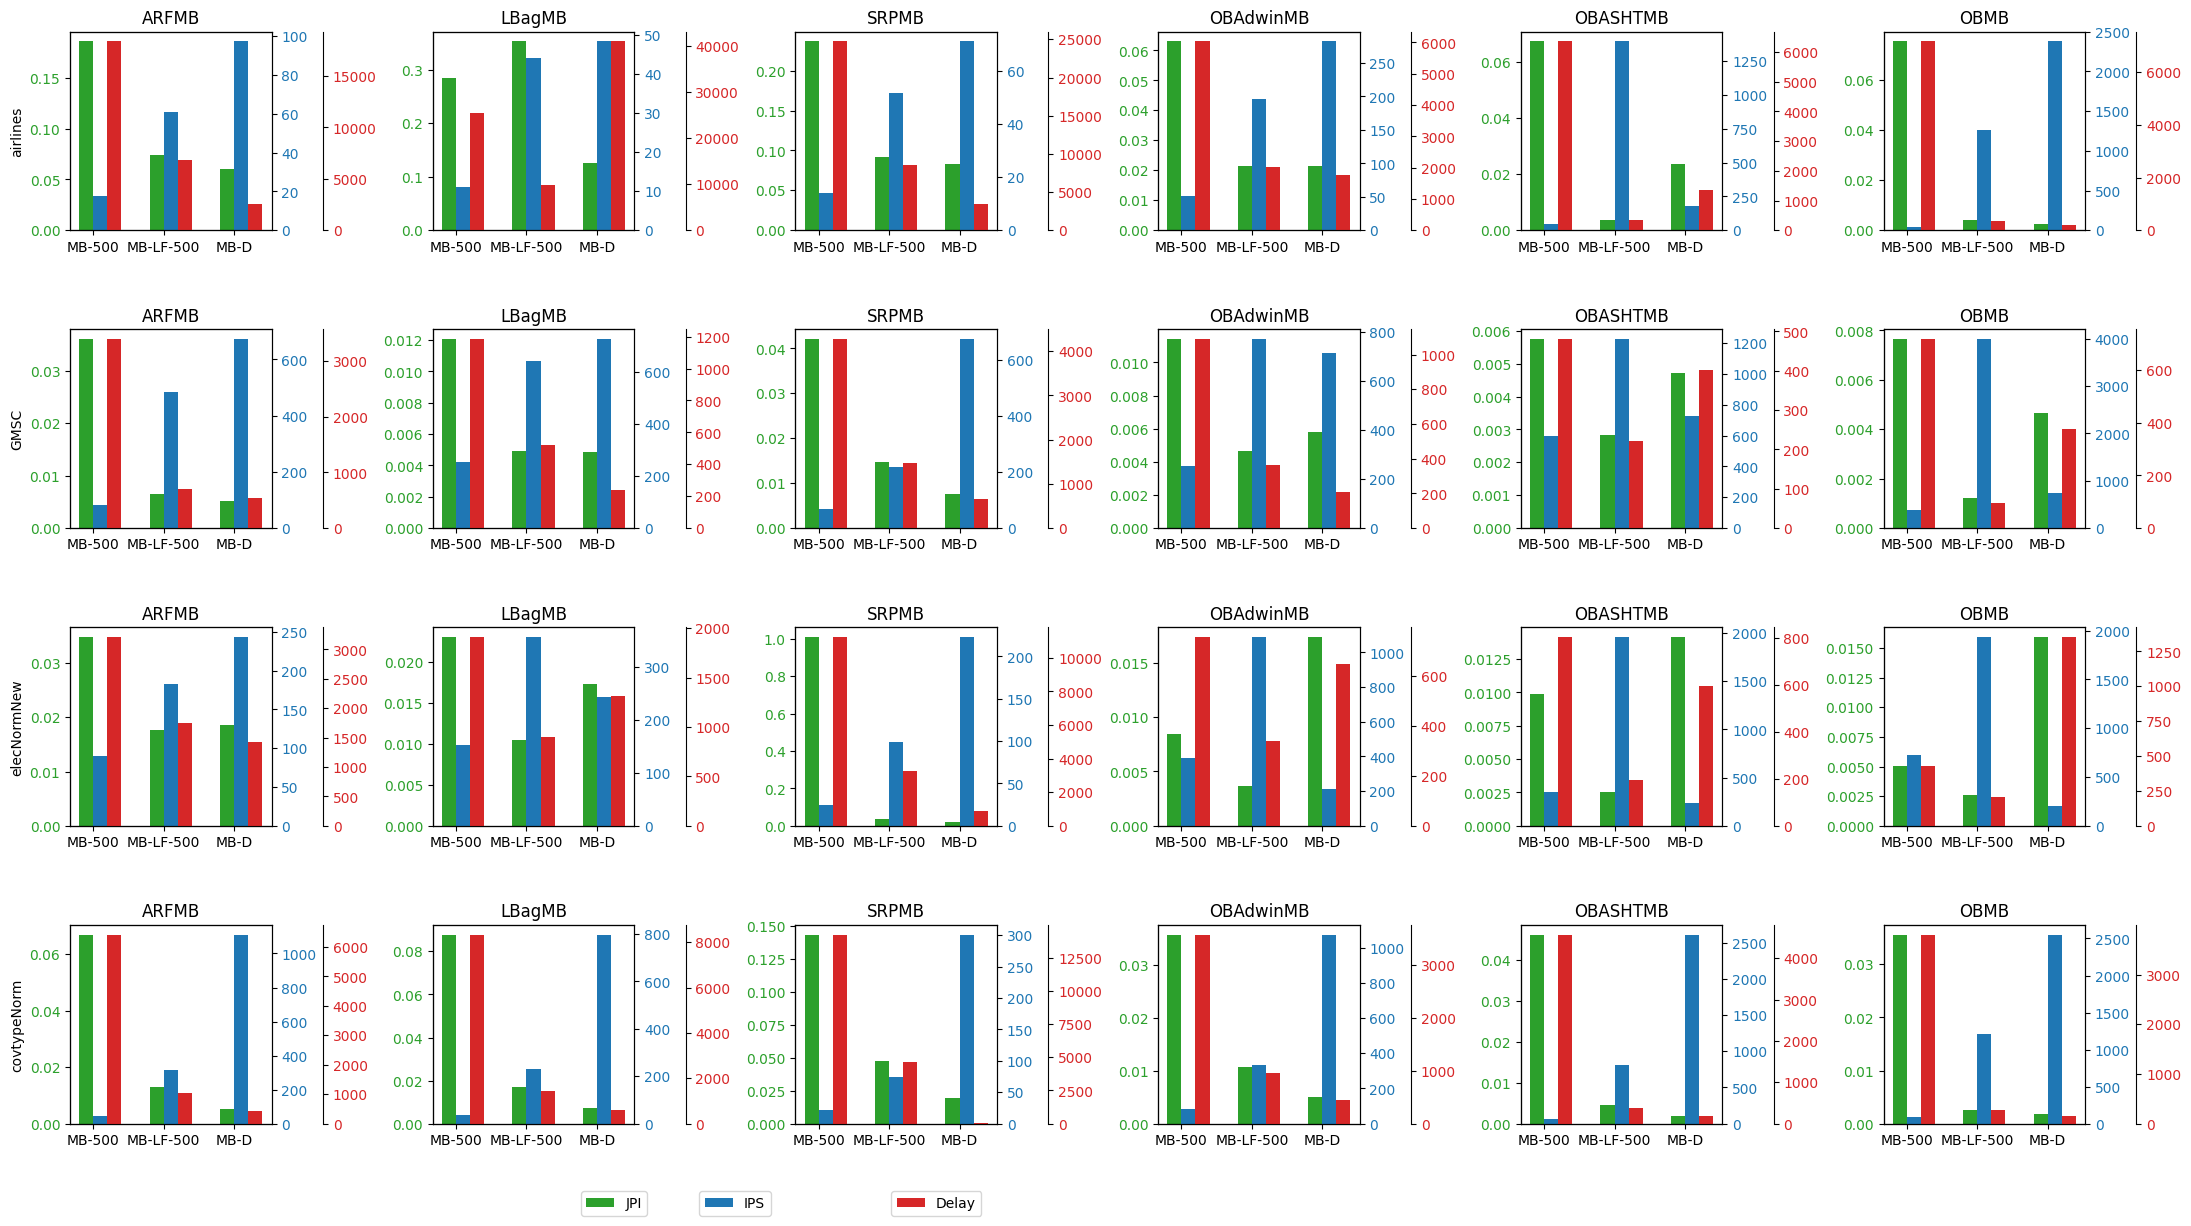

In [1051]:
df = pd.concat([mb_socket_dynamic, mblf_socket_dynamic, mblf_mb_and_socket_dynamic])

df = df.loc[:, ['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_graph_joules(df, None)

## calculate median and maximums

In [1052]:
def generate_reduction_percentage(df):
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    response = {
        'airlines': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'GMSC': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'elecNormNew': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'covtypeNorm': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        }
    }

    for ds in datasets:
        current_df = df[(df.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:            
            dfalg = filter_by_substring_algorithm(
                current_df.reset_index(), alg
            )

            dfalg = dfalg.iloc[1: , :].fillna(0) # remove duplicidade sequencial
            my_id = algorithms.index(alg)

            joules_mbd = dfalg[dfalg.label == 'MB-D']['joules'].iloc[0]
            joules_mblf = dfalg[dfalg.label == 'MB-LF']['joules'].iloc[0]
            
            response[ds][alg] = {
                'joules_mbd': joules_mbd,
                'joules_mblf': joules_mblf,
                'reducao_mbd': (joules_mbd / joules_mblf)
            }

    return response
            

In [1053]:
def generate_median_all(df_90):
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    total_mbd = []
    for ds in datasets:
        for alg in algorithms:
            total_mbd.append(df_90[ds][alg]['reducao_mbd'])
            # total_mbd.append(df_50[ds][alg]['reducao_mbd'])
            # total_mbd.append(df_10[ds][alg]['reducao_mbd'])

    print({
        'mbd_median': round(np.mean(total_mbd) * 100, 2),
        'mbd_maximum': round(np.max(total_mbd) * 100, 2),
    })

In [1054]:
# df_generate = generate_reduction_percentage(pd.concat([mb_socket_dynamic, mblf_socket_dynamic, mblf_mb_and_socket_dynamic]))
# df_generate_50 = generate_reduction_percentage(pd.concat([df_50, df_mbd]))
# df_generate_10 = generate_reduction_percentage(pd.concat([df_10, df_mbd]))

# generate_median_all(df_generate)



## Average value and maximum value when compare sequential mode

- Em média MB-D obteve 123% de melhoria na eficiência energética, e 185% de melhoria no melhor caso. 

In [1055]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.label

    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
  
    ax.plot(x, pd.to_numeric(df.acc), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg.replace("RUNPER", "").replace("Sequential", "")}')
    
    # ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    # ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    #ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(40,100)

In [1063]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey='row')
    filename = datetime.datetime.now()
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id)]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart

            df_mapping = pd.DataFrame({
                'label': [f'MB-{MB_SIZE}', f'MB-LF-{MB_SIZE}', 'MB-D'],
            })
            sort_mapping = df_mapping.reset_index().set_index('label')
            df_aux['label_num'] = df_aux['label'].map(sort_mapping['index'])

            df_aux = df_aux.drop_duplicates().sort_values('label_num')
            display(df_aux)

            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%4 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
#             if int(my_id/2) == 1:
#                 ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)), bbox_to_anchor=(0.5,-0.10))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=1200)

,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
81,airlines,ARFMB,500,64.5844,"10,713.0000",599.2640,0.1860,"1,970.3339",4,MB-500,"18,402.0000",17.8769,0
47,airlines,ARFMB,500,66.7972,"36,500.0000",601.1070,0.0738,"2,676.1658",4,MB-LF-500,"6,821.0000",60.7213,1
11,airlines,ARFMB,50-2000,65.0979,"11,751.0000",120.5970,0.0606,645.8695,4,MB-D,"2,537.0000",97.4402,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
36,airlines,LBagMB,500,62.5203,"6,650.0000",599.2720,0.2841,"1,859.0530",4,MB-500,"25,563.0000",11.0968,0
94,airlines,LBagMB,500,58.2885,"26,500.0000",599.2830,0.3534,"3,492.5941",4,MB-LF-500,"9,926.0000",44.2195,1
7,airlines,LBagMB,50-2000,63.7833,"6,001.0000",123.8140,0.1256,686.0399,4,MB-D,"41,114.0000",48.4679,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
25,airlines,SRPMB,500,65.1130,"8,374.0000",599.2590,0.2369,"1,949.1457",4,MB-500,"24,765.0000",13.9739,0
78,airlines,SRPMB,500,68.0548,"31,500.0000",606.3460,0.0917,"2,870.5522",4,MB-LF-500,"8,515.0000",51.9505,1
8,airlines,SRPMB,50-2000,64.8457,"8,751.0000",122.5750,0.0835,668.6643,4,MB-D,"3,462.0000",71.3930,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
48,airlines,OBAdwinMB,500,64.4211,"30,633.0000",599.2920,0.0631,"1,911.3193",4,MB-500,"6,043.0000",51.1153,0
46,airlines,OBAdwinMB,500,67.9838,"117,500.0000",599.3630,0.0215,"2,493.9976",4,MB-LF-500,"2,035.0000",196.0415,1
4,airlines,OBAdwinMB,50-2000,66.7382,"34,001.0000",120.2460,0.0215,661.6025,4,MB-D,"1,764.0000",282.7620,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
54,airlines,OBASHTMB,500,64.7110,"28,333.0000",599.2890,0.0673,"1,882.0958",4,MB-500,"6,365.0000",47.2777,0
118,airlines,OBASHTMB,500,61.6145,"531,500.0000",380.0720,0.0038,"1,981.9364",4,MB-LF-500,356.0000,"1,398.4193",1
3,airlines,OBASHTMB,50-2000,64.9169,"22,251.0000",121.7720,0.0236,477.1658,4,MB-D,"1,365.0000",182.7267,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
84,airlines,OBMB,500,63.5519,"27,500.0000",605.1260,0.0755,"2,056.3841",4,MB-500,"7,183.0000",45.4451,0
56,airlines,OBMB,500,59.9586,"524,500.0000",415.2820,0.0039,"2,012.1259",4,MB-LF-500,361.0000,"1,262.9972",1
21,airlines,OBMB,50-2000,62.3276,"286,001.0000",120.0570,0.0024,621.6063,4,MB-D,209.0000,"2,382.2101",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
79,GMSC,ARFMB,500,93.4111,"48,702.0000",599.3250,0.0361,"1,741.1188",4,MB-500,"3,402.0000",81.2614,0
112,GMSC,ARFMB,500,93.5358,"150,000.0000",308.7490,0.0065,965.3880,4,MB-LF-500,704.0000,485.8315,1
20,GMSC,ARFMB,50-2000,93.5130,"80,501.0000",119.6140,0.0053,386.2829,4,MB-D,534.0000,673.0065,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
49,GMSC,LBagMB,500,93.5010,"150,000.0000",592.6120,0.0121,"1,792.1026",4,MB-500,"1,186.0000",253.1167,0
117,GMSC,LBagMB,500,93.5030,"150,000.0000",233.3590,0.0049,718.3048,4,MB-LF-500,521.0000,642.7865,1
1,GMSC,LBagMB,50-2000,93.4241,"87,001.0000",119.4560,0.0048,377.4512,4,MB-D,236.0000,728.3100,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
73,GMSC,SRPMB,500,93.4351,"41,186.0000",599.3090,0.0421,"1,717.8361",4,MB-500,"4,277.0000",68.7225,0
88,GMSC,SRPMB,500,93.5096,"131,000.0000",599.8790,0.0147,"1,917.8518",4,MB-LF-500,"1,481.0000",218.3774,1
9,GMSC,SRPMB,50-2000,93.4981,"80,501.0000",119.5530,0.0076,552.7832,4,MB-D,649.0000,673.3499,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
33,GMSC,OBAdwinMB,500,93.5197,"150,000.0000",597.4670,0.0114,"1,694.1947",4,MB-500,"1,090.0000",251.0599,0
106,GMSC,OBAdwinMB,500,93.4323,"149,000.0000",193.3330,0.0047,674.8933,4,MB-LF-500,363.0000,770.6910,1
18,GMSC,OBAdwinMB,50-2000,93.4718,"85,001.0000",119.2750,0.0058,441.5650,4,MB-D,209.0000,712.6472,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
10,GMSC,OBASHTMB,500,93.3492,"150,000.0000",250.4530,0.0058,844.7097,4,MB-500,481.0000,598.9148,0
75,GMSC,OBASHTMB,500,93.2963,"149,000.0000",121.3450,0.0028,400.4908,4,MB-LF-500,221.0000,"1,227.9039",1
16,GMSC,OBASHTMB,50-2000,93.3133,"86,501.0000",119.1800,0.0047,368.8596,4,MB-D,403.0000,725.8013,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
23,GMSC,OBMB,500,93.5217,"150,000.0000",392.3780,0.0077,"1,132.3766",4,MB-500,718.0000,382.2844,0
7,GMSC,OBMB,500,93.4365,"148,500.0000",37.1740,0.0012,154.6438,4,MB-LF-500,95.0000,"3,994.7275",1
10,GMSC,OBMB,50-2000,93.4724,"87,001.0000",119.1360,0.0046,361.7088,4,MB-D,376.0000,730.2662,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
40,elecNormNew,ARFMB,500,78.1666,"45,312.0000",504.2930,0.0348,"1,560.1291",4,MB-500,"3,214.0000",89.8525,0
54,elecNormNew,ARFMB,500,88.7303,"45,000.0000",246.1520,0.0176,776.1378,4,MB-LF-500,"1,746.0000",182.8139,1
12,elecNormNew,ARFMB,50-2000,88.8655,"29,001.0000",119.0970,0.0186,491.1000,4,MB-D,"1,421.0000",243.5074,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
20,elecNormNew,LBagMB,500,77.6377,"45,312.0000",297.2000,0.0231,"1,027.2689",4,MB-500,"1,912.0000",152.4630,0
120,elecNormNew,LBagMB,500,88.7933,"45,000.0000",126.3040,0.0105,452.9505,4,MB-LF-500,897.0000,356.2833,1
5,elecNormNew,LBagMB,50-2000,89.0586,"29,001.0000",119.0850,0.0174,450.9912,4,MB-D,"1,315.0000",243.5319,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
4,elecNormNew,SRPMB,500,81.1015,"14,681.0000",599.2750,1.0110,"1,844.2145",4,MB-500,"11,254.0000",24.4979,0
93,elecNormNew,SRPMB,500,89.6584,"45,000.0000",454.2480,0.0343,"1,527.9300",4,MB-LF-500,"3,284.0000",99.0648,1
13,elecNormNew,SRPMB,50-2000,90.2579,"26,751.0000",119.8380,0.0206,505.2833,4,MB-D,895.0000,223.2264,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
76,elecNormNew,OBAdwinMB,500,77.9367,"45,312.0000",116.0980,0.0085,362.6110,4,MB-500,756.0000,390.2910,0
43,elecNormNew,OBAdwinMB,500,84.3213,"45,000.0000",41.2690,0.0037,145.0653,4,MB-LF-500,341.0000,"1,090.4068",1
15,elecNormNew,OBAdwinMB,50-2000,86.5647,"25,501.0000",119.2330,0.0174,397.2784,4,MB-D,646.0000,213.8754,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
5,elecNormNew,OBASHTMB,500,77.2583,"45,312.0000",128.0880,0.0099,428.8576,4,MB-500,806.0000,353.7568,0
1,elecNormNew,OBASHTMB,500,77.6930,"43,500.0000",22.1980,0.0025,84.6402,4,MB-LF-500,196.0000,"1,959.6360",1
6,elecNormNew,OBASHTMB,50-2000,77.9036,"28,222.0000",119.0850,0.0142,360.8425,4,MB-D,596.0000,236.9904,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
43,elecNormNew,OBMB,500,77.0568,"45,241.0000",62.0510,0.0051,205.8025,4,MB-500,430.0000,729.0938,0
91,elecNormNew,OBMB,500,73.8471,"43,000.0000",22.1970,0.0026,89.1231,4,MB-LF-500,205.0000,"1,937.1987",1
22,elecNormNew,OBMB,50-2000,79.0041,"24,501.0000",119.0810,0.0159,349.5349,4,MB-D,"1,355.0000",205.7507,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
3,covtypeNorm,ARFMB,500,66.9510,"26,758.0000",599.3050,0.0669,"1,772.9760",4,MB-500,"6,420.0000",44.6484,0
99,covtypeNorm,ARFMB,500,90.5273,"189,000.0000",599.7420,0.0130,"2,438.9325",4,MB-LF-500,"1,032.0000",315.1355,1
19,covtypeNorm,ARFMB,50-2000,89.7476,"133,501.0000",120.1470,0.0053,647.1784,4,MB-D,442.0000,"1,111.1471",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
96,covtypeNorm,LBagMB,500,65.3329,"20,943.0000",599.2860,0.0878,"1,817.9256",4,MB-500,"8,333.0000",34.9466,0
66,covtypeNorm,LBagMB,500,92.2146,"137,500.0000",599.8480,0.0169,"2,299.3991",4,MB-LF-500,"1,418.0000",229.2247,1
17,covtypeNorm,LBagMB,50-2000,91.5469,"96,001.0000",120.3560,0.0073,627.3371,4,MB-D,614.0000,797.6420,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
39,covtypeNorm,SRPMB,500,58.6437,"13,093.0000",599.2840,0.1435,"1,861.6255",4,MB-500,"14,241.0000",21.8477,0
50,covtypeNorm,SRPMB,500,91.3303,"45,000.0000",599.3310,0.0474,"2,115.9469",4,MB-LF-500,"4,616.0000",75.0837,1
14,covtypeNorm,SRPMB,50-2000,93.2697,"36,151.0000",120.0470,0.0196,649.7227,4,MB-D,81.0000,301.1404,2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
9,covtypeNorm,OBAdwinMB,500,79.4649,"51,291.0000",599.3380,0.0357,"1,815.0987",4,MB-500,"3,579.0000",85.5794,0
90,covtypeNorm,OBAdwinMB,500,85.0801,"201,500.0000",599.3550,0.0107,"2,140.1853",4,MB-LF-500,958.0000,336.1948,1
2,covtypeNorm,OBAdwinMB,50-2000,83.1081,"129,501.0000",120.4560,0.0051,592.9720,4,MB-D,457.0000,"1,075.0896",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
22,covtypeNorm,OBASHTMB,500,71.2861,"38,997.0000",599.3540,0.0463,"1,781.1881",4,MB-500,"4,571.0000",65.0651,0
6,covtypeNorm,OBASHTMB,500,76.8551,"487,000.0000",599.3910,0.0046,"2,211.7692",4,MB-LF-500,383.0000,812.4914,1
0,covtypeNorm,OBASHTMB,50-2000,76.0810,"313,501.0000",120.0570,0.0020,565.1721,4,MB-D,177.0000,"2,611.2680",2


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS,label_num
90,covtypeNorm,OBMB,500,75.7235,"50,433.0000",599.3430,0.0356,"1,778.5271",4,MB-500,"3,807.0000",84.1471,0
33,covtypeNorm,OBMB,500,76.1391,"576,500.0000",478.1660,0.0026,"1,494.0359",4,MB-LF-500,278.0000,"1,205.6483",1
23,covtypeNorm,OBMB,50-2000,79.0987,"304,001.0000",119.0830,0.0019,514.9722,4,MB-D,159.0000,"2,552.8497",2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


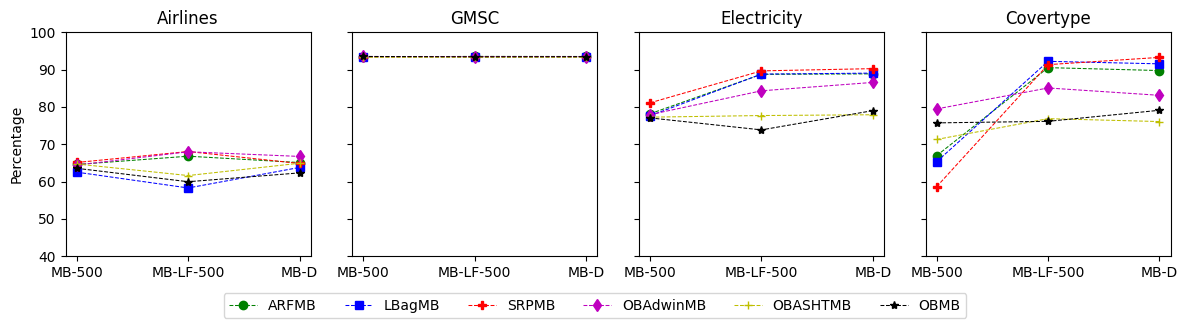

In [1064]:
#false makes the chart without markers
df = pd.concat([mb_socket_dynamic, mblf_socket_dynamic, mblf_mb_and_socket_dynamic])

df = df.loc[:, ['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_chart(df, True, False)